In [1]:
!pip install numpy


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [22]:
import sys
!{sys.executable} -m pip install -U pip numpy
!{sys.executable} -m pip install -U pip torch
!{sys.executable} -m pip install -U pip matplotlib

  Using cached contourpy-1.3.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pillow-12.0.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (8.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 3.9 MB/s  0:00:02 eta 0:00:01
Using cached contourpy-1.3.3-cp311-cp311-macosx_11_0_arm64.whl (270 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 3.8 MB/s  0:00:00 eta 0:00:01
Using cached kiwisolver-1.4.9-cp311-cp311-macosx_11_0_arm64.whl (65 kB)
Using cached pillow-12.0.0-cp311-cp311-macosx_11_0_arm64.whl (4.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]


In [9]:
# importing libraries
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from typing import Tuple, Dict

Regression based uncertainity implementation
1. creating a dataset
2. initialize data loaders for testing/training
3. create model with mc drop out and aleatoric uncertainity
4. train
5. mc dropout and uncertainity decomp
6. plots

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [15]:
def make_heteroscedastic_regression(n=6000, seed=0):
    rng = np.random.default_rng(seed)
    x = rng.uniform(-3, 3, size=(n, 1)).astype(np.float32)
    # true function
    y_true = np.sin(x) + 0.3 * x
    # input-dependent noise: sigma(x) grows with |x|
    sigma = 0.1 + 0.15 * (np.abs(x) ** 1.2)
    y = y_true + rng.normal(0, sigma, size=y_true.shape).astype(np.float32)
    return x, y, y_true, sigma

x, y, y_true, sigma = make_heteroscedastic_regression()
x_train, y_train = x[:5000], y[:5000]
x_test, y_test = x[5000:], y[5000:]
x_train.shape, y_train.shape, x_test.shape


((5000, 1), (5000, 1), (1000, 1))

In [16]:
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
test_ds  = TensorDataset(torch.from_numpy(x_test),  torch.from_numpy(y_test))

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=512, shuffle=False)


In [18]:
class RegrNet(nn.Module):
    def __init__(self, in_dim=1, hidden=128, p_drop=0.1):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(p_drop),
        )
        self.mu_head = nn.Linear(hidden, 1)
        self.logvar_head = nn.Linear(hidden, 1)  # s = log(sigma^2)

    def forward(self, x):
        h = self.backbone(x)
        mu = self.mu_head(h)
        s = self.logvar_head(h)
        return mu, s

def heteroscedastic_gaussian_nll(mu, logvar, y):
    # 0.5 * exp(-logvar) * (y-mu)^2 + 0.5 * logvar
    return 0.5 * torch.exp(-logvar) * (y - mu).pow(2) + 0.5 * logvar

model_r = RegrNet(p_drop=0.15).to(device)
model_r


RegrNet(
  (backbone): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.15, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.15, inplace=False)
  )
  (mu_head): Linear(in_features=128, out_features=1, bias=True)
  (logvar_head): Linear(in_features=128, out_features=1, bias=True)
)

In [19]:
def train_regression(model, epochs=50, lr=1e-3, wd=1e-4):
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

    for ep in range(1, epochs + 1):
        model.train()
        total = 0.0
        n = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            mu, logvar = model(xb)
            loss = heteroscedastic_gaussian_nll(mu, logvar, yb).mean()
            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()
            total += loss.item() * xb.size(0)
            n += xb.size(0)

        if ep % 10 == 0 or ep == 1:
            print(f"epoch {ep:3d} | train NLL {total/n:.4f}")

train_regression(model_r, epochs=60, lr=2e-3)


epoch   1 | train NLL 0.1054
epoch  10 | train NLL -0.5278
epoch  20 | train NLL -0.5544
epoch  30 | train NLL -0.5500
epoch  40 | train NLL -0.5640
epoch  50 | train NLL -0.5710
epoch  60 | train NLL -0.5596


In [ ]:
@torch.no_grad()
def mc_dropout_predict_regression(model, x: torch.Tensor, T=50):
    
    model.train()  # keep dropout 
    mus = []
    sig2s = []
    for _ in range(T):
        mu, logvar = model(x)
        mus.append(mu)
        sig2s.append(torch.exp(logvar)) # sigma^2
    #[T,N,1]
    mu_stack = torch.stack(mus, dim=0) 
    # T,N,1]
    sig2_stack = torch.stack(sig2s, dim=0)   

    mu_mean = mu_stack.mean(dim=0)
    epistemic_var = mu_stack.var(dim=0, unbiased=False)
    aleatoric_var = sig2_stack.mean(dim=0)
    total_var = epistemic_var + aleatoric_var
    return mu_mean, epistemic_var, aleatoric_var, total_var

#Run on test set
x_t = torch.from_numpy(x_test).to(device)
mu_mean, epi_var, ale_var, tot_var = mc_dropout_predict_regression(model_r, x_t, T=80)

# debugging 
print("mean predictive std:", torch.sqrt(tot_var).mean().item())
print("mean epistemic std:", torch.sqrt(epi_var).mean().item())
print("mean aleatoric std:", torch.sqrt(ale_var).mean().item())


mean predictive std: 0.413463830947876
mean epistemic std: 0.11296524852514267
mean aleatoric std: 0.3975279629230499


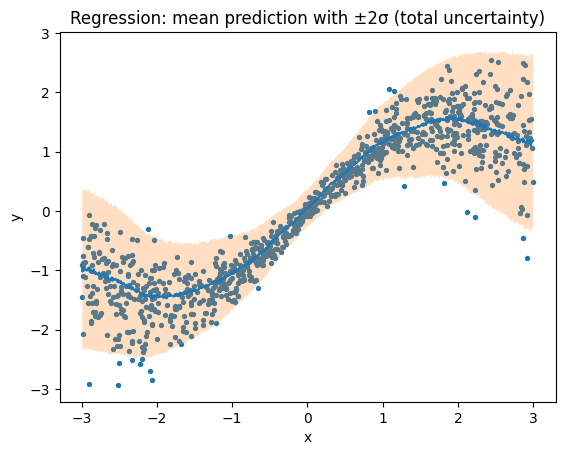

In [23]:
import matplotlib.pyplot as plt

x_plot = x_test.squeeze()
order = np.argsort(x_plot)

x_sorted = x_plot[order]
mu_sorted = mu_mean.squeeze().detach().cpu().numpy()[order]
std_sorted = torch.sqrt(tot_var).squeeze().detach().cpu().numpy()[order]

y_sorted = y_test.squeeze()[order]

plt.figure()
plt.scatter(x_sorted, y_sorted, s=8)
plt.plot(x_sorted, mu_sorted)
plt.fill_between(x_sorted, mu_sorted - 2*std_sorted, mu_sorted + 2*std_sorted, alpha=0.25)
plt.title("Regression: mean prediction with ±2σ (total uncertainty)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()
